In this study, we look at how the difference between st22 and the average of the  neighboring stations (st 21 and 23). In this data set, the trolley is directly underneath station 22.
The difference has been made positive (absolute value of the difference)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy
import math

#import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old
import allantools

In [18]:
def plt_unix_time_to_CST(ax):
    ax.locator_params(axis='x', nbins=5)
    xticks = ax.get_xticks()
    ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                        for tm in xticks], rotation=0, fontdict={'size':12, 'family':'serif'})

def difference(y, avgt):      ##Compresses an array by averaging over the given averaging time to "bin" the data, difference is a misleading name
    t = np.arange(int(avgt) , len(y), int(avgt))
    N = len(t)
    Sum = 0
    avgdiff = np.array([])
    for i in y:
        Sum += i
        if (np.where(y == i)[0][0]% avgt == 0) and (np.where(y == i)[0][0] > 0):
            avg = Sum/avgt
            Sum = 0
            avgdiff = np.append(avgdiff, avg)
            
        
    return (t,avgdiff)

def line(x,m,b): #just a line equation
    return m*x + b

def Multiplot(x_data, y_data, height, width, dimension, sublabels = None, x_axis_labels = None, y_axis_labels = None, figname = None, CST = False, daylines = False, day_offset = 0, logscale = False, day_label = ""):
    #x_data is an array containing arrays with the different data to plot
    #y_data ""
    #width is the width of the whole figure in inches
    #height is the height of the whole figure in inches
    #dimension is an array containing the dimensions of the plot figure np.array([3,2])  would correspond to 6 plots (3 rows, 2 cols)
    #x_axis_labels labels is an array containing the labels on the subplots
    #Similarly for y
    #sublabels are the titles are the subplots (1 x n array of strings), can just be 1 x 1 if all the same
    #Figname is the name of the plot
    #CST will convert the x-axis data into CST time
    #Daylines will plot red lines to show days.
    #day_offset in case we want the 24 hour mark to be somewhere else other than just 24 hours from the start
    for i in range(len(x_data)):
        if len(x_data[i]) != len(y_data[i]):
            print("The dimensions of x[" + str(i) + "] and y[" + str(i) + "] do not match")
    
    equal_x_labels = True
    for k in range(len(x_axis_labels)):
        for l in range(len(x_axis_labels)):
            if k != l:
                if  x_axis_labels[k] != x_axis_labels:
                    equal_x_labels = False
                    
    equal_y_labels = True
    for k in range(len(y_axis_labels)):
        for l in range(len(y_axis_labels)):
            if k != l:
                if  y_axis_labels[k] != y_axis_labels:
                    equal_y_labels = False
    day = np.array([86400,86400])
    fig, axs = plt.subplots(dimension[0], dimension[1], constrained_layout=True)
    fig.set_figheight(height)
    fig.set_figwidth(width)
    for i in range(dimension[0]):
        for j in range(dimension[1]):
            axs[i,j].plot(x_data[dimension[1] * i + j], y_data[dimension[1] * i + j])
            if equal_x_labels:
                axs[i,j].set_xlabel(x_axis_labels[0])
            else:
                axs[i,j].set_xlabel(x_axis_labels[dimension[1] * i + j])
            if equal_y_labels:
                axs[i,j].set_ylabel(y_axis_labels[0])
            else:
                axs[i,j].set_ylabel(y_axis_labels[dimension[1] * i + j])
            axs[i,j].set_title(sublabels[dimension[1] * i + j])
            if daylines:
                days = int((x_data[dimension[1] * i + j].max() - x_data[dimension[1] * i + j].min()) / 86400)
                for n in range(days):
                    axs[i,j].plot(day * (n+1) + day_offset + x_data[dimension[1] * i + j][0], [y_data[dimension[1] * i + j].min(), y_data[dimension[1] * i + j].max()], 'r', label = day_label)
                    axs[i,j].legend()
            if logscale:
                axs[i,j].set_xscale('log')
                axs[i,j].set_yscale('log')
            if CST:
                plt_unix_time_to_CST(axs[i,j])
    fig.suptitle(figname)
            

In [6]:
filename = 'hdf5/superlong_1.h5'
sl_interp_df = pd.read_hdf(filename)
#sl_interp_df.head()

In [4]:
sl_moment_df = helper.calc_moment_df(sl_interp_df)

Finished calculating all moments for 252363 events.                                                   


In [5]:
#sl_moment_df.head()
run_start = sl_moment_df.index.values[0]  #I forgot to keep the times on arrays, was still getting used to CST time

In [12]:
T = sl_moment_df.index.to_numpy()
st22m1_list = sl_moment_df["st22,m1"].to_numpy()
st21m1_list = sl_moment_df["st21,m1"].to_numpy()
st23m1_list = sl_moment_df["st23,m1"].to_numpy()

st22m2_list = sl_moment_df["st22,m2"].to_numpy()
st21m2_list = sl_moment_df["st21,m2"].to_numpy()
st23m2_list = sl_moment_df["st23,m2"].to_numpy()

st22m3_list = sl_moment_df["st22,m3"].to_numpy()
st21m3_list = sl_moment_df["st21,m3"].to_numpy()
st23m3_list = sl_moment_df["st23,m3"].to_numpy()

st22m4_list = sl_moment_df["st22,m4"].to_numpy()
st21m4_list = sl_moment_df["st21,m4"].to_numpy()
st23m4_list = sl_moment_df["st23,m4"].to_numpy()

st22m5_list = sl_moment_df["st22,m5"].to_numpy()
st21m5_list = sl_moment_df["st21,m5"].to_numpy()
st23m5_list = sl_moment_df["st23,m5"].to_numpy()

st22m6_list = sl_moment_df["st22,m6"].to_numpy()
st21m6_list = sl_moment_df["st21,m6"].to_numpy()
st23m6_list = sl_moment_df["st23,m6"].to_numpy()

In [14]:
t = np.logspace(0, math.log(len(st22m1_list),10), 50)  # tau values from 1 to length of columns
#station averages
sa1 = (st21m1_list + st23m1_list)/2
sa2 = (st21m2_list + st23m2_list)/2
sa3 = (st21m3_list + st23m3_list)/2
sa4 = (st21m4_list + st23m4_list)/2
sa5 = (st21m5_list + st23m5_list)/2
sa6 = (st21m6_list + st23m6_list)/2
#difference between station average and station 22
ss1 = abs(st22m1_list-sa1) # The m1 measured by the station 22 is higher than the average always
ss2 = abs(st22m2_list-sa2) # The m2 measured by the station 22 is higher than the average always
ss3 = abs(st22m3_list-sa3) # The m3 measured by the station 22 is higher than the average always
ss4 = abs(st22m4_list-sa4) # The m4 measured by the station average is higher than station 22 always
ss5 = abs(st22m5_list-sa5) # The m5 measured by the station average is higher than station 22 always
ss6 = abs(st22m6_list-sa6) # The m6 measured by the station 22 is higher than the average always

In [15]:
t = np.logspace(0, math.log(len(st22m1_list),10), 50)  # tau values from 1 to length of columns
r = 1 # sample rate in Hz of the input data
#Computing Allan Deviations of the differences:
(ts1, ads1, ade, adn) = allantools.oadev(ss1, rate=r, data_type="freq", taus = t)  # Compute the overlapping ADEV
(ts2, ads2, ade, adn) = allantools.oadev(ss2, rate=r, data_type="freq", taus = t)
(ts3, ads3, ade, adn) = allantools.oadev(ss3, rate=r, data_type="freq", taus = t)  
(ts4, ads4, ade, adn) = allantools.oadev(ss4, rate=r, data_type="freq", taus = t)
(ts5, ads5, ade, adn) = allantools.oadev(ss5, rate=r, data_type="freq", taus = t) 
(ts6, ads6, ade, adn) = allantools.oadev(ss6, rate=r, data_type="freq", taus = t) 

#time where the allan deviations are at minimum (best averaging time):
avgts1 = ts1[np.where(ads1==ads1.min())][0]
avgts2 = ts2[np.where(ads2==ads2.min())][0]
avgts3 = ts3[np.where(ads3==ads3.min())][0]
avgts4 = ts4[np.where(ads4==ads4.min())][0]
avgts5 = ts5[np.where(ads5==ads5.min())][0]
avgts6 = ts6[np.where(ads6==ads6.min())][0]

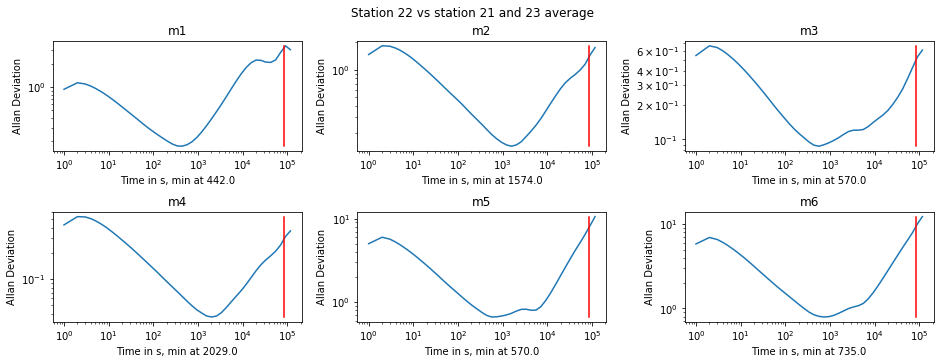

In [16]:
#Plots Allan Deviations:
day  = np.array([86400, 86400])
ads1m = np.array([min(ads1), max(ads1)])         #st22 vs avg
ads2m = np.array([min(ads2), max(ads2)])
ads3m = np.array([min(ads3), max(ads3)])
ads4m = np.array([min(ads4), max(ads4)])
ads5m = np.array([min(ads5), max(ads5)])
ads6m = np.array([min(ads6), max(ads6)])

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(13)
axs[0,0].plot(ts1, ads1, day, ads1m, 'r')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].set_xlabel("Time in s, min at " + str(avgts1))
axs[0,0].set_ylabel("Allan Deviation")
axs[0,0].set_title('m1')

axs[0,1].plot(ts2,ads2, day, ads2m, 'r')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].set_xlabel("Time in s, min at " + str(avgts2))
axs[0,1].set_ylabel("Allan Deviation")
axs[0,1].set_title('m2')

axs[0,2].plot(ts3,ads3, day, ads3m, 'r')
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].set_xlabel("Time in s, min at " + str(avgts3))
axs[0,2].set_ylabel("Allan Deviation")
axs[0,2].set_title('m3')

axs[1,0].plot(ts4,ads4, day, ads4m, 'r')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_xlabel("Time in s, min at " + str(avgts4))
axs[1,0].set_ylabel("Allan Deviation")
axs[1,0].set_title('m4')

axs[1,1].plot(ts5,ads5, day, ads5m, 'r')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].set_xlabel("Time in s, min at " + str(avgts5))
axs[1,1].set_ylabel("Allan Deviation")
axs[1,1].set_title('m5')

axs[1,2].plot(ts6,ads6, day, ads6m, 'r')
axs[1,2].set_xscale('log')
axs[1,2].set_yscale('log')
axs[1,2].set_xlabel("Time in s, min at " + str(avgts6))
axs[1,2].set_ylabel("Allan Deviation")
axs[1,2].set_title('m6')
fig.suptitle("Station 22 vs station 21 and 23 average")

plt.show()

m = 0.9477416843715415 +- [ 1.33017561e-08 -6.76662657e-04]
m = 0.49496351923772197 +- [2.24283156e-06 2.67165212e-03]
m = 0.4800914037380702 +- [2.26450097e-06 9.70225143e-04]
m = 0.3958348255326968 +- [1.82469061e-06 3.10662601e-03]
m = 0.32988874377491734 +- [6.88674253e-05 2.33286659e-01]
m = 0.47368308771016193 +- [6.72485733e-05 2.90048330e-02]


Text(0.5,0.98,'station 22 and st21&23 average')

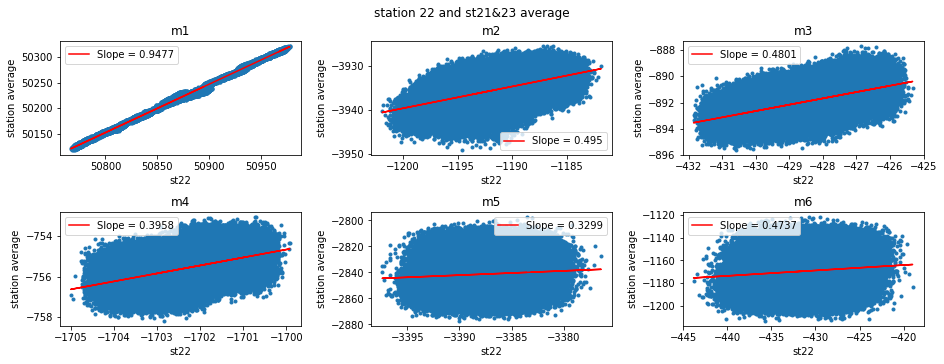

In [19]:
#Fitting a line to the unbinned data (Correlation)
vars1, cov1 = curve_fit(line,st22m1_list, sa1)
print("m = " + str(vars1[0]) + " +- " + str(cov1[0]))
vars2, cov2 = curve_fit(line,st22m2_list, sa2)
print("m = " + str(vars2[0]) + " +- " + str(cov2[0]))
vars3, cov3 = curve_fit(line,st22m3_list, sa3)
print("m = " + str(vars3[0]) + " +- " + str(cov3[0]))
vars4, cov4 = curve_fit(line,st22m4_list, sa4)
print("m = " + str(vars4[0]) + " +- " + str(cov4[0]))
vars5, cov5 = curve_fit(line,st22m5_list, sa5)
print("m = " + str(vars5[0]) + " +- " + str(cov5[0]))
vars6, cov6 = curve_fit(line,st22m6_list, sa6)
print("m = " + str(vars6[0]) + " +- " + str(cov6[0]))

Text(0.5,0.98,'station 22 and st21&23 average')

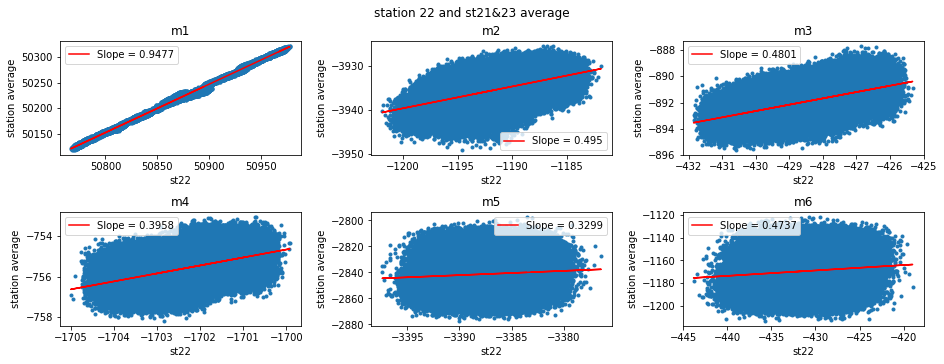

In [20]:
#Plotting the data and the line of best fit
fig, axs = plt.subplots(2,3, constrained_layout = True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(st22m1_list, sa1,'.')
axs[0,0].plot(st22m1_list, line(st22m1_list, *vars1), 'r', label = "Slope = " + str(round(vars1[0], 4)))
axs[0,0].set_xlabel("st22")
axs[0,0].set_ylabel("station average")
axs[0,0].set_title("m1")
axs[0,0].legend()

axs[0,1].plot(st22m2_list, sa2,'.')
axs[0,1].plot(st22m2_list, line(st22m2_list, *vars2), 'r', label = "Slope = " + str(round(vars2[0], 4)))
axs[0,1].set_xlabel("st22")
axs[0,1].set_ylabel("station average")
axs[0,1].set_title("m2")
axs[0,1].legend()

axs[0,2].plot(st22m3_list, sa3,'.')
axs[0,2].plot(st22m3_list, line(st22m3_list, *vars3), 'r', label = "Slope = " + str(round(vars3[0], 4)))
axs[0,2].set_xlabel("st22")
axs[0,2].set_ylabel("station average")
axs[0,2].set_title("m3")
axs[0,2].legend()

axs[1,0].plot(st22m4_list, sa4,'.')
axs[1,0].plot(st22m4_list, line(st22m4_list, *vars4), 'r', label = "Slope = " + str(round(vars4[0], 4)))
axs[1,0].set_xlabel("st22")
axs[1,0].set_ylabel("station average")
axs[1,0].set_title("m4")
axs[1,0].legend()

axs[1,1].plot(st22m5_list, sa5,'.')
axs[1,1].plot(st22m5_list, line(st22m5_list, *vars5), 'r', label = "Slope = " + str(round(vars5[0], 4)))
axs[1,1].set_xlabel("st22")
axs[1,1].set_ylabel("station average")
axs[1,1].set_title("m5")
axs[1,1].legend()

axs[1,2].plot(st22m6_list, sa6,'.')
axs[1,2].plot(st22m6_list, line(st22m6_list, *vars6), 'r', label = "Slope = " + str(round(vars6[0], 4)))
axs[1,2].set_xlabel("st22")
axs[1,2].set_ylabel("station average")
axs[1,2].set_title("m6")
axs[1,2].legend()

fig.suptitle("station 22 and st21&23 average")

In [21]:
#Binning data
(Tss1, Dss1) =  difference(ss1,avgts1)
print("1 run(s) done")
(Tss2, Dss2) =  difference(ss2,avgts2)
print("2 run(s) done")
(Tss3, Dss3) =  difference(ss3,avgts3)
print("3 run(s) done")
(Tss4, Dss4) =  difference(ss4,avgts4)
print("4 run(s) done")
(Tss5, Dss5) =  difference(ss5,avgts5)
print("5 run(s) done")
(Tss6, Dss6) =  difference(ss6,avgts6)
print("6 run(s) done")

1 run(s) done
2 run(s) done
3 run(s) done
4 run(s) done
5 run(s) done
6 run(s) done


In [22]:
#The time was set to start at 0 in the allan deviation plots, we must add back the starting time
Tss1 = Tss1 + run_start
Tss2 = Tss2 + run_start
Tss3 = Tss3 + run_start
Tss4 = Tss4 + run_start
Tss5 = Tss5 + run_start
Tss6 = Tss6 + run_start

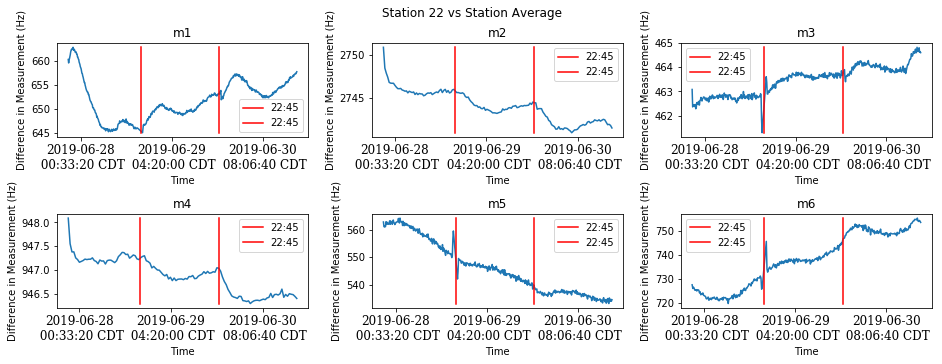

In [23]:
#Plotting data
lss1 = min(Dss1) #station to station average
hss1 = max(Dss1)
lss2 = min(Dss2)
hss2 = max(Dss2)
lss3 = min(Dss3)
hss3 = max(Dss3)
lss4 = min(Dss4)
hss4 = max(Dss4)
lss5 = min(Dss5)
hss5 = max(Dss5)
lss6 = min(Dss6)
hss6 = max(Dss6)

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(Tss1, Dss1)
#axs[0,0].plot(Tss1, Dss1, '.')
axs[0,0].plot(day - 6400 + run_start, [lss1,hss1], 'r', 2*day - 6400 + run_start, [lss1,hss1], 'r', label = "22:45")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("Difference in Measurement (Hz)")
axs[0,0].set_title('m1')

axs[0,1].plot(Tss2, Dss2)
#axs[0,1].plot(Tss2, Dss2, '.')
axs[0,1].plot(day - 6400 + run_start, [lss2,hss2], 'r', 2*day - 6000 + run_start, [lss2,hss2], 'r', label = "22:45")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Difference in Measurement (Hz)")
axs[0,1].set_title('m2')

axs[0,2].plot(Tss3, Dss3)
#axs[0,2].plot(Tss3, Dss3, '.')
axs[0,2].plot(day - 6400 + run_start, [lss3,hss3], 'r', 2*day - 6400 + run_start, [lss3,hss3], 'r', label = "22:45")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_ylabel("Difference in Measurement (Hz)")
axs[0,2].set_title('m3')

axs[1,0].plot(Tss4, Dss4)
#axs[1,0].plot(Tss4, Dss4, '.')
axs[1,0].plot(day - 6400 + run_start, [lss4,hss4], 'r', 2*day - 6400 + run_start, [lss4,hss4], 'r', label = "22:45")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Difference in Measurement (Hz)")
axs[1,0].set_title('m4')

axs[1,1].plot(Tss5, Dss5)
#axs[1,1].plot(Tss5, Dss5, '.')
axs[1,1].plot(day - 6400 + run_start, [lss5,hss5], 'r', 2*day - 6400 + run_start, [lss5,hss5], 'r', label = "22:45")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Difference in Measurement (Hz)")
axs[1,1].set_title('m5')

axs[1,2].plot(Tss6, Dss6)
#axs[1,2].plot(Tss6, Dss6, '.')
axs[1,2].plot(day - 6400 + run_start, [lss6,hss6], 'r', 2*day - 6400 + run_start, [lss6,hss6], 'r', label = "22:45")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_ylabel("Difference in Measurement (Hz)")
axs[1,2].set_title('m6')
fig.suptitle("Station 22 vs Station Average")
plt.show() 


#plt.plot(Tss1,Dss1,".")
#plt.plot([86400, 86400], [l1, h1], "r")
#plt.plot([86400*2, 86400*2], [l1, h1], "r")
#plt.title("st22m1 and st average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()

#plt.plot(Tss2,Dss2,".")
#plt.plot([86400, 86400], [l2, h2], "r")
#plt.plot([86400*2, 86400*2], [l2, h2], "r")
#plt.title("st22m2 and st average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()

#plt.plot(Tss3,Dss3,".")
#plt.plot([86400, 86400], [l3, h3], "r")
#plt.plot([86400*2, 86400*2], [l3, h3], "r")
#plt.title("st22m3 and st average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()

#plt.plot(Tss4,Dss4,".")
#plt.plot([86400, 86400], [l4, h4], "r")
#plt.plot([86400*2, 86400*2], [l4, h4], "r")
#plt.title("st22m4 and st average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()

#plt.plot(Tss5,Dss5,".")
#plt.plot([86400, 86400], [l5, h5], "r")
#plt.plot([86400*2, 86400*2], [l5, h5], "r")
#plt.title("st22m5 and st average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()

#plt.plot(Tss6,Dss6,".")
#plt.plot([86400, 86400], [l6, h6], "r")
#plt.plot([86400*2, 86400*2], [l6, h6], "r")
#plt.title("st22m6 and st average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()